# OBP calculation for well

OBP calculation include the following step:

1. Extrapolate density log to the surface
2. Calculate Overburden Pressure


- Calculate Hydrostatic Pressrue (*)

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
# for python 2 and 3 compatibility
# from builtins import str
# try:
#     from pathlib import Path
# except:
#     from pathlib2 import Path
#--------------------------------------------
import sys
ppath = "../.."

if ppath not in sys.path:
    sys.path.append(ppath)
#---------------------------------------------

In [2]:
from __future__ import print_function, division, unicode_literals
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

import numpy as np

import pygeopressure as ppp

## 1. Extrapolate density log to the surface

Create survey with the example survey `CUG`:

In [18]:
# set to the directory on your computer
SURVEY_FOLDER = "M:/CUG_depth"

survey = ppp.Survey(SURVEY_FOLDER)

Retrieve well `CUG1`:

In [4]:
well_cug1 = survey.wells['CUG1']

Get density log:

In [5]:
den_log = well_cug1.get_log("Density")

View density log:

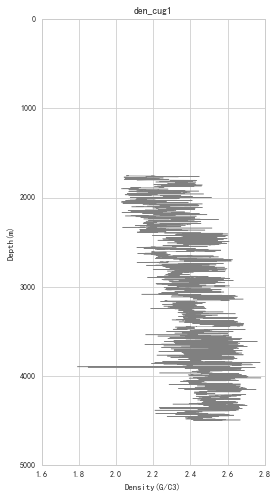

In [6]:
fig_den, ax_den = plt.subplots()
ax_den.invert_yaxis()

den_log.plot(ax_den)

# set style
ax_den.set(ylim=(5000,0), aspect=(1.2/5000)*2)
fig_den.set_figheight(8)
fig_den.show()

Find optimized coefficients for Traugott equation:

In [7]:
a, b = ppp.optimize_traugott(
    den_log, 2000, 3000, kb=well_cug1.kelly_bushing, wd=well_cug1.water_depth)

View fitted density trend:

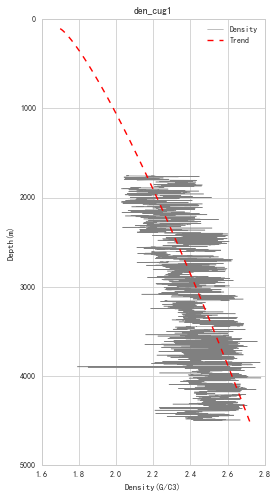

In [8]:
fig_den, ax_den = plt.subplots()
ax_den.invert_yaxis()
# draw density log
den_log.plot(ax_den, label='Density')
# draw fitted density trend line
den_trend = ppp.traugott_trend(
    np.array(den_log.depth), a, b, 
    kb=well_cug1.kelly_bushing, wd=well_cug1.water_depth)

ax_den.plot(den_trend, den_log.depth, 
            color='r', linestyle='--', zorder=2, label='Trend')

# set style
ax_den.set(ylim=(5000,0), aspect=(1.2/5000)*2)
ax_den.legend()
fig_den.set_figheight(8)
fig_den.show()

Since we will extrapolate density to mudline (sea bottom), density values of the inverval from mudline to kelly bushing will be NaN (See figure above).

Also, the actual variation of rock density underground doesnot have such high frequency as density logging data, so we need to perform some filtering and smoothing of the original signal.

Density log processing (filtering and smoothing):

In [9]:
den_log_filter = ppp.upscale_log(den_log, freq=20)

den_log_filter_smooth = ppp.smooth_log(den_log_filter, window=1501)

View processed log data:

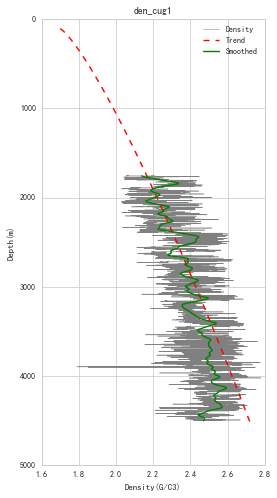

In [10]:
fig_den, ax_den = plt.subplots()
ax_den.invert_yaxis()
# draw density log
den_log.plot(ax_den, label='Density')
# draw fitted density trend line
ax_den.plot(den_trend, den_log.depth, 
            color='r', linestyle='--', zorder=2, label='Trend')
# draw processed density log
ax_den.plot(den_log_filter_smooth.data, den_log_filter_smooth.depth,
            color='g', zorder=3, label='Smoothed')

# set style
ax_den.set(ylim=(5000,0), aspect=(1.2/5000)*2)
ax_den.legend()
fig_den.set_figheight(8)
fig_den.show()

Extrapolate processed density log with fitted trend:

In [11]:
extra_log = ppp.extrapolate_log_traugott(
    den_log_filter_smooth, a, b, 
    kb=well_cug1.kelly_bushing, wd=well_cug1.water_depth)

View extraploted density log:

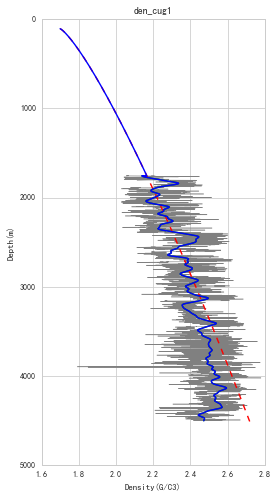

In [12]:
fig_den, ax_den = plt.subplots()
ax_den.invert_yaxis()
# draw density log
den_log.plot(ax_den, label='Density')
# draw trend line
ax_den.plot(den_trend, den_log.depth, 
            color='r', linestyle='--', zorder=2, label='Trend')
# draw processed density log
ax_den.plot(den_log_filter_smooth.data, den_log_filter_smooth.depth,
            color='g', zorder=3, label='Smoothed')
# draw extrapolated density
ax_den.plot(extra_log.data, extra_log.depth, 
            color='b', zorder=4, label='Extrapolated')

# set style
ax_den.set(ylim=(5000,0), aspect=(1.2/5000)*2)
fig_den.set_figheight(8)
fig_den.show()

The extrapolated log (blue line in the figure above) is used for calculation of Overburden Pressure.

## 2. Calculation of Overburden Pressure

In [13]:
obp_log = ppp.obp_well(extra_log, 
         kb=well_cug1.kelly_bushing, wd=well_cug1.water_depth, 
         rho_w=1.01)

## * Calculation of Hydrostatic Pressure

Since parameters used for hydrostatic pressrue calcualtion like kelly busshing and water depth are store in Well, so we add a shortcut for hydrostatic pressure calculation in Well.

In [14]:
# hydro_log = ppp.hydrostatic_well(
#     obp_log.depth, kb=well_cug1.kelly_bushing, wd=well_cug1.water_depth, 
#     rho_f=1., rho_w=1.)

hydro_log = well_cug1.hydro_log()

View calcualted overburden pressure:

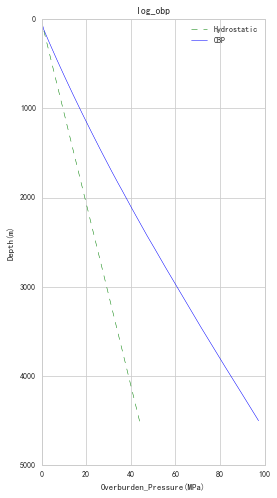

In [15]:
fig_obp, ax_obp = plt.subplots()
ax_obp.invert_yaxis()

hydro_log.plot(ax_obp, color='g', linestyle='--', label='Hydrostatic')

obp_log.plot(ax_obp, color='b', label='OBP')

# set style
ax_obp.set(ylim=(5000,0), aspect=(100/5000)*2)
ax_obp.legend()
fig_obp.set_figheight(8)
fig_obp.show()

Save calculated Overburden Pressure:

In [16]:
# well_cug1.add_log("Overbuden_Pressure")

*optional, calculated overburden pressure has already been saved, so users don't need to run these notebooks in specific order.*